# Task Description

The dataset for this task deals with the video game Rocket League, where the player controls a car and tries to score goals on a soccer field. The game involves advanced mechanics, where the player can jump with the car or activate a boost. This lends itself to do sophisticated sequences of moves in order to score goals. There are several classes of trick shots and your task is to use the information about the state of the game at different timestamps, in order to classify which trick shot was performed.

The dataset contains 297 separate trick shots. Every trick shot consists of a summary statistic and subsequently arbitrarily many timestamps, each indicating different in-game metrics and player inputs. The summary statistics consist of median values and the skew over the whole recorded window. The metrics measured are:

    BallAcceleration: The current acceleration of the football.
    DistanceWall: The current player's distance to the closest wall.
    DistanceCeil: The current player's distance to the ceiling.
    DistanceBall: The current player's distance to the ball.
    PlayerSpeed: The current speed of the player's car.
    BallSpeed: The current speed of the ball.

Additionally, the keyboard inputs are also recorded:

    up
    accelerate
    slow
    goal
    left
    boost
    camera
    down
    right
    slide
    jump

For better identification, an id column was added, identifying a unique trick shot as well as a window_id column, that identifies the sequence of timestamps within one trick shot.

The task is to classify each trick shot with one label. This means all rows with the same id only need one prediction. The available labels are:

- -1: noise (no trickshot)
- 1: ceiling shot
- 2: power shot
- 3: waving dash
- 5: air dribble
- 6: front flick
- 7: musty flick

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)



# Loading the dataset

In [2]:
# load dataset

data = pd.read_csv('data/rocketskillshots_train.csv')
data.head()


,id,window_id,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,up,...,slow_skew,goal_skew,left_skew,boost_skew,camera_skew,down_skew,right_skew,slide_skew,jump_skew,label
0,0,NaN,0.000000,2.205022,3817.38,2013.00,NaN,150959.239888,145648.061660,0.0,...,5.656854,3.795046,0.0,1.428526,3.795046,0.0,-1.681134,1.428526,1.021592,6
1,0,0.0,1636.798772,0.000000,3498.01,2012.98,NaN,104267.426232,99035.849337,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
2,0,1.0,3198.029397,0.138893,3494.08,2012.98,229.89678,124248.031988,102233.878734,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
3,0,2.0,0.000000,0.173617,3494.08,2012.98,NaN,124248.031988,102968.358990,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
4,0,3.0,9914.766242,0.312510,3500.08,2012.98,NaN,115248.016009,112883.125231,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


# Preprocessing

In [3]:
# split in train and validation set using ids
unique_ids = data['id'].unique()

train_ids, val_ids = train_test_split(unique_ids, test_size=0.2, random_state=8) # split ids

train_data = data[data['id'].isin(train_ids)].copy()
val_data = data[data['id'].isin(val_ids)].copy()


In [4]:
# Columns to aggregate
numeric_columns = [
    "BallAcceleration", "DistanceWall", "DistanceCeil", 
    "DistanceBall", "PlayerSpeed", "BallSpeed"
]

keyboard_columns = [
    "up", "accelerate", "slow", "goal", 
    "left", "boost", "camera", "down", 
    "right", "slide", "jump"
]


# Aggregation functions for the columns of a time series
agg_funcs = {
    **{col: ['mean', 'median', 'std', 'min', 'max', ] for col in numeric_columns},
    **{col: ['mean', 'median', 'std', 'min', 'max'] for col in keyboard_columns},
}




# Fill in NaN values before aggregating
train_data.fillna(train_data.mean(numeric_only=True), inplace=True)
val_data.fillna(train_data.mean(numeric_only=True), inplace=True)

# Aggregate train and test data separately
train_aggregated = train_data.groupby('id').agg(agg_funcs)
val_aggregated = val_data.groupby('id').agg(agg_funcs)

# Flatten MultiIndex columns
train_aggregated.columns = ['_'.join(col) for col in train_aggregated.columns]
val_aggregated.columns = ['_'.join(col) for col in val_aggregated.columns]

# Add the label column back
train_aggregated['label'] = train_data.groupby('id')['label'].first()
val_aggregated['label'] = val_data.groupby('id')['label'].first()


# Train models

In [5]:
X_train = train_aggregated.drop(columns=['label'])
y_train = train_aggregated['label']

X_val = val_aggregated.drop(columns=['label'])
y_val = val_aggregated['label']

## Logistic Regression GridSearch

Best parameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validated score: 0.8166371158392435

Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.50      0.67         6
           1       0.75      1.00      0.86         3
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.25      0.20      0.22         5
           7       0.60      0.75      0.67         8

    accuracy                           0.75        36
   macro avg       0.77      0.78      0.76        36
weighted avg       0.76      0.75      0.74        36



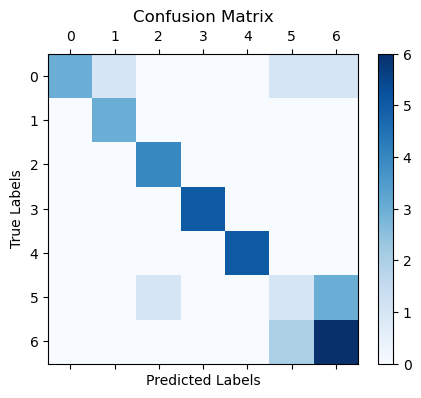

In [6]:
param_grid = {
    'solver': ['lbfgs', 'newton-cg'],
    'C': [0.01, 0.1, 10, 100],
    'max_iter': [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=8),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)
# Data needs to be scaled for LogisticRegression
# Scale the training and validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Fit
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

best_model = grid_search.best_estimator_


# Evaluate on full validation set
y_val_pred = best_model.predict(X_val_scaled)
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(range(conf_matrix.shape[1]), range(conf_matrix.shape[1]))
plt.yticks(range(conf_matrix.shape[0]), range(conf_matrix.shape[0]))
plt.show()




## Random Forest Grid Search

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'n_estimators': 1000}
Best cross-validated score: 0.8380614657210401

Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.50      0.67         6
           1       0.50      1.00      0.67         3
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       0.56      1.00      0.71         5
           7       0.75      0.38      0.50         8

    accuracy                           0.75        36
   macro avg       0.80      0.81      0.76        36
weighted avg       0.82      0.75      0.74        36



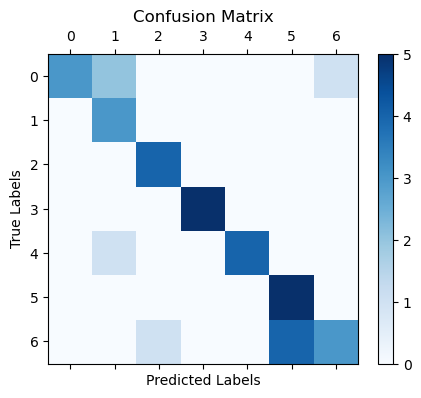

In [7]:
param_grid = {
    'n_estimators': [500, 1000],  # Number of trees in the forest
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=8),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)


# Fit 
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Evaluate on full validation set
y_val_pred = best_model.predict(X_val)
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(range(conf_matrix.shape[1]), range(conf_matrix.shape[1]))
plt.yticks(range(conf_matrix.shape[0]), range(conf_matrix.shape[0]))
plt.show()


## KNN

Best parameters: {'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best cross-validated score: 0.7609338061465721

Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.17      0.29         6
           1       0.60      1.00      0.75         3
           2       0.40      0.50      0.44         4
           3       0.83      1.00      0.91         5
           5       0.83      1.00      0.91         5
           6       0.29      0.40      0.33         5
           7       0.67      0.50      0.57         8

    accuracy                           0.61        36
   macro avg       0.66      0.65      0.60        36
weighted avg       0.68      0.61      0.59        36



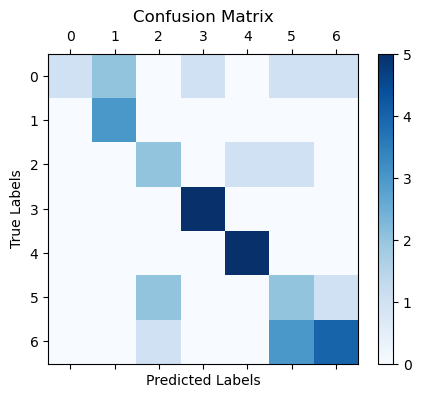

In [8]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}



grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1
)

# Scale the training and validation data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Fit 
grid_search.fit(X_train_scaled, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

best_model = grid_search.best_estimator_
# Evaluate on full validation set
y_val_pred = best_model.predict(X_val_scaled)
print("\nClassification Report:\n")
print(classification_report(y_val, y_val_pred))
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
plt.matshow(conf_matrix, cmap='Blues', fignum=1)
plt.colorbar()
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(range(conf_matrix.shape[1]), range(conf_matrix.shape[1]))
plt.yticks(range(conf_matrix.shape[0]), range(conf_matrix.shape[0]))
plt.show()


# Submission

## Load datasets

In [9]:
train_data = pd.read_csv('data/rocketskillshots_train.csv') # load whole dataset again to make sure we have the whole training data
test_data = pd.read_csv('data/rocketskillshots_test.csv') # load test set for submission

## Preprocessing

In [10]:
# Columns to aggregate
numeric_columns = [
    "BallAcceleration", "DistanceWall", "DistanceCeil", 
    "DistanceBall", "PlayerSpeed", "BallSpeed"
]

keyboard_columns = [
    "up", "accelerate", "slow", "goal", 
    "left", "boost", "camera", "down", 
    "right", "slide", "jump"
]

# Define aggregation functions
agg_funcs = {
    **{col: ['mean', 'median', 'std', 'min', 'max'] for col in numeric_columns},
    **{col: ['sum', 'mean', 'median', 'std', 'min', 'max'] for col in keyboard_columns},
}

In [11]:
train_data.fillna(train_data.median(numeric_only=True), inplace=True)
test_data.fillna(train_data.median(numeric_only=True), inplace=True)

# Aggregate train and test data separately
train_aggregated = train_data.groupby('id').agg(agg_funcs)
test_aggregated = test_data.groupby('id').agg(agg_funcs)

# Flatten MultiIndex columns
train_aggregated.columns = ['_'.join(col) for col in train_aggregated.columns]
test_aggregated.columns = ['_'.join(col) for col in test_aggregated.columns]

# Add the label column back
train_aggregated['label'] = train_data.groupby('id')['label'].first()

In [12]:
X_train = train_aggregated.drop(columns=['label'])
y_train = train_aggregated['label']

X_test = test_aggregated

## Train on whole training data with final model

In [13]:

model = RandomForestClassifier(criterion='entropy', max_depth=None, max_features=None, n_estimators=1000, random_state=8)

model.fit(X_train, y_train)



RandomForestClassifier(criterion='entropy', max_features=None,
                       n_estimators=1000, random_state=8)

## Predict and create submission file

In [14]:

predictions = model.predict(X_test)


submission = pd.DataFrame({
    'ID': X_test.index,  
    'label': predictions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Workflow Explanation

## How I processed my data

To process the data effectively, I began by splitting it into a training set and a validation set, ensuring that all rows associated with the same id remained within the same dataset. This consistency was crucial, as the data represents a time series, where multiple rows of varying lengths correspond to a single instance of a "move."

Given the structure of the data, I aggregated all rows corresponding to the same id into a single representation. Before performing the aggregation, I handled missing values (NaN) by replacing them with the column-wise mean. During aggregation, I calculated various statistical measures—including the mean, median, sum, standard deviation (std), minimum, and maximum for each move. This preprocessing was applied consistently to both the training and validation datasets.

## How I chose my model and the parameters

I experimented with three different model types: Logistic Regression, Random Forest, and K-Nearest Neighbors. For each model, I followed a consistent procedure. First, I defined a grid of hyperparameters specific to the model and performed a grid search using `GridSearchCV` from Scikit-learn. This approach not only optimized the hyperparameters but also incorporated cross-validation to ensure robust evaluation. Importantly, only the training set was used during this step.

After identifying the best parameters for each model, I evaluated their performance using the validation set. I predicted the labels for the validation data and generated a detailed classification report, including metrics such as precision, recall, and F1-score. Additionally, I visualized the performance through a confusion matrix to gain deeper insights into each model's strengths and weaknesses.

After evaluating the performance of three models—Logistic Regression, Random Forest, and K-Nearest Neighbors—using GridSearchCV for hyperparameter optimization, I selected the Random Forest model, as it demonstrated superior performance during cross-validation. To maximize the model's effectiveness, I retrained it using the entire training dataset, thereby leveraging all available information. Subsequently, I applied this fully trained model to predict labels for the test set, preparing the results for submission.

